In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import clear_output
from IPython.display import HTML
import pickle
# from google.colab import files

In [2]:
import numpy as np
from pathlib import Path
from torchvision import transforms
import torch
from torch import nn
import torchvision.utils as vutils

In [3]:
from utils import visual_data, load_cifar10
from networks import Generator, Discriminator, weights_init
from trainer import  batch_fake_samples,  update_params
from losses import D_loss, G_featMatch_loss, G_loss

In [4]:
# Setting up constants
# device
ngpu = 0

# single image
imageSize = 64
imageMean = (0.4923172 , 0.48307145, 0.4474483)
imageStd = (0.24041407, 0.23696952, 0.25565723)

# data loader
numWorkers = 1
batchSize = 16

# Network Arch
nc = 3 # Number of channels
nz = 100 # Latent vector
ngf = 16 # relates to the depth of feature maps carried through the generator
ndf = 16 # sets the depth of feature maps propagated through the discriminator

# Training
num_epochs = 1

# Adam Optimizer
lr = .001
beta1 = .5

# convention of the labeling for the real and the fake datasets
## one-sided label smoothing
real_label = .9
fake_label = 0

# label smoothing
## insdead of real label=.9 give uniform between .8, 1
## insdead of fake label=0 give uniform between 0, .2
label_smoothing = True

# flip labels, with probability pFlip, flip the labels passed to the discriminator
pFlip = 0.05

# if to use last two layers' features for feature matching
double_layer = True

# inner loop repetitions
D_inner_repeat = 1
G_inner_repeat = 1

In [5]:
# folder to store/load data
dataFolder = Path("./data")
# Decide which device to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [6]:
cifarFolder = dataFolder/"CIFAR10"
# prepare data for loading
tsfms = transforms.Compose([
    transforms.Resize(imageSize), 
    transforms.ToTensor(),
    transforms.Normalize(imageMean, imageStd)
])
trainLoader, test_loader = load_cifar10(cifarFolder, tsfms, batchSize, numWorkers)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# init D and G network
gen = Generator(ngpu, nz, ngf, nc).to(device)
gen.apply(weights_init);
disc = Discriminator(ngpu, nc, ndf).to(device)
disc.apply(weights_init);

In [8]:
# setup optmization 
optimizerD = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))

In [9]:
# fixed noise z for viusalization of the progress of the training
fixed_noise = torch.randn(batchSize, nz, 1, 1, device=device)

# training loop 
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

Starting Training Loop...


In [10]:
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the trainLoader
    for i, data in enumerate(trainLoader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################   
        for _ in range(D_inner_repeat):
            # real batch and fake batch
            real_batch = data[0].to(device)
            fake_batch = batch_fake_samples(real_batch.size(0), gen, nz, device)
            
            # forward pass
            output_real, f1real, f2real = disc(real_batch)
            output_fake, _, _ = disc(fake_batch.detach())
            
            # loss for D
            errD = D_loss(output_real, output_fake, 
                          real_label, fake_label, 
                          pFlip, label_smoothing,
                          device)
            
            # backward pass and optimization step
            update_params(optimizerD, errD)
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        for _ in range(G_inner_repeat):
            # fake batch 
            fake_batch = batch_fake_samples(real_batch.size(0), gen, nz, device)
            
            # forward pass
            output, f1fake, f2fake = disc(fake_batch)
            
            # loss function
            errG = G_featMatch_loss(f1fake, f2fake, 
                                    f1real.detach(), f2real.detach(), double_layer)
            
            errG += .1*G_loss(output, real_label, label_smoothing, device)
            
            # backward pass and optimization step
            update_params(optimizerG, errG)

        ###########################
        # (3) save and print progress
        ###########################
        # for progress prints
        D_x = output_real.mean().item()
        D_G_z1 = output_fake.mean().item()
        D_G_z2 = output.mean().item()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(trainLoader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(trainLoader)-1)):
            clear_output()
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

[0/1][2550/3125]	Loss_D: 1.0338	Loss_G: 1.2225	D(x): 0.6472	D(G(z)): 0.3524 / 0.3456
[0/1][2600/3125]	Loss_D: 1.3858	Loss_G: 1.1990	D(x): 0.5212	D(G(z)): 0.4380 / 0.3695
[0/1][2650/3125]	Loss_D: 1.4340	Loss_G: 1.3342	D(x): 0.7063	D(G(z)): 0.6096 / 0.3591
[0/1][2700/3125]	Loss_D: 1.0389	Loss_G: 1.3549	D(x): 0.6654	D(G(z)): 0.3704 / 0.2254
[0/1][2750/3125]	Loss_D: 1.5431	Loss_G: 1.3145	D(x): 0.2951	D(G(z)): 0.0922 / 0.1836
[0/1][2800/3125]	Loss_D: 1.2440	Loss_G: 1.1162	D(x): 0.5704	D(G(z)): 0.4469 / 0.4335
[0/1][2850/3125]	Loss_D: 0.9722	Loss_G: 1.2917	D(x): 0.6129	D(G(z)): 0.2534 / 0.2377


KeyboardInterrupt: 

In [ ]:
len(G_losses)

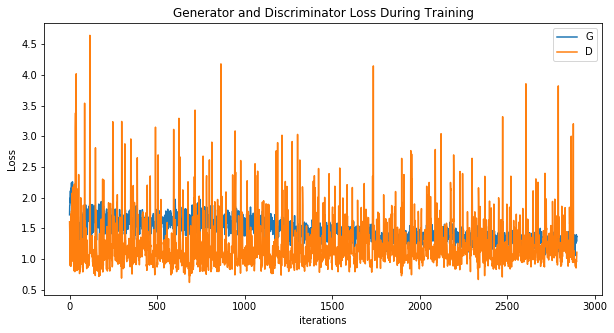

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
trainIter = iter(trainLoader)

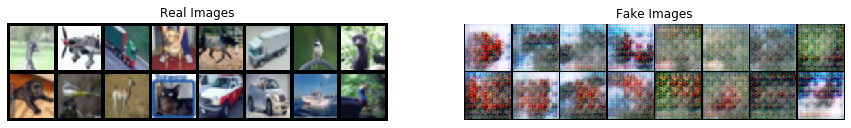

In [16]:
real_batch = next(trainIter)

noise = torch.randn(batchSize, nz, 1, 1, device=device)
fake = gen(noise).detach().cpu()
fake = vutils.make_grid(fake, padding=2, normalize=True)

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(fake,(1,2,0)))
plt.show()

In [ ]:
# print(optimizerD, optimizerG, trainLoader.batch_size, ngf, ndf, real_label)

In [ ]:
# genParams = gen.state_dict()
# discParams = disc.state_dict()

In [ ]:
# def dumpAndDL(variable, fileName):
#     with open(fileName, 'wb') as f:
#         pickle.dump(variable,
#                     f)
#         files.download(fileName)
        
# def chunks(lst, n):
#     """Yield successive n-sized chunks from lst."""
#     for i in range(0, len(lst), n):
#         yield lst[i:i + n]

In [ ]:
# dumpAndDL(
#     {'genParams': genParams,
#      'discParams': discParams,
#     },
#     'bestParams.p'
# )

In [ ]:
# dumpAndDL(
#     {'G_losses': G_losses,
#      'D_losses':D_losses,
#      },
#      'losses.p'
#        )

In [ ]:
# n=50
# for idx, chunk in enumerate(chunks(img_list, n)):
#     fileName = 'img_list_{}.p'.format(idx)
#     dumpAndDL(
#         chunk,
#         fileName
#     )

In [ ]:
# # load params to networks
# fileName = 'bestParams.p'
# netParams = None
# with open(fileName, 'rb') as f:
#      netParams = pickle.load(f)
# gen.load_state_dict(netParams['genParams'])
# disc.load_state_dict(netParams['discParams'])

In [ ]:
# # load params to networks
# fileNames = ['img_list_0.p', 'img_list_1.p', 'img_list_2.p', 'img_list_3.p']

# img_list = []
# for fileName in fileNames:
#     with open(fileName, 'rb') as f:
#         img_list += pickle.load(f)['img_list']


In [ ]:
# len(img_list)

In [ ]:
# #%%capture animation
# fig = plt.figure(figsize=(10, 10))
# plt.axis("off")
# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list[:100]]
# ani = animation.ArtistAnimation(fig, ims, interval=100, repeat_delay=1000, blit=True)

# HTML(ani.to_jshtml())

# # writer = animation.writers['ffmpeg']
# # ani.save('im.mp4', writer=writer, dpi=100)